<a href="https://colab.research.google.com/github/pratap977/CS6910/blob/main/Assignment-2/Part-A/PartA_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 5.2 MB/s 
     |████████████████████████████████| 181 kB 38.4 MB/s 
     |████████████████████████████████| 144 kB 60.7 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=b1a9e6773a8e0e76b55bbc16c2d34048fd6e2fcd32a6067fc942fc59e6e77683
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import math as mh
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Activation,Dense,Flatten
from keras.preprocessing.image import load_img as im
from keras.preprocessing.image import save_img as sim
import os
from random import shuffle
import numpy as np
import splitfolders
from PIL import Image
from torchvision import transforms
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers,models
import wandb
import pathlib
# import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#gettig labels for different classes and assigning values
class_labels = os.listdir("/content/drive/MyDrive/outputfin/train")
lab={l:i for l,i in zip(class_labels,range(10))}




##############################################################
#function for prepating data takes two parameters
#1.drive_path - path to drive i.e training or validataion or test
#2.want_aug - Takes 'YES' or 'NO' values to gather info wheter to augment data or not
def prepare_data(drive_path,want_aug):
  imgs_tr = []
  truth_tr = []
  #data augmentation rules here
  data_augmentation  = transforms.Compose([
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ])
  for l in class_labels:
    #### for each folder in the val dir we iterate though all the files 
    if l.startswith("."):
      continue
    imgs_per_class = os.listdir(os.path.join(drive_path, l)) #getting list of file names
    for img in imgs_per_class:
      #iterating to each file in the folder 
      img_path = os.path.join(drive_path, l, img)
      img=Image.open(img_path)
      img = img.resize((224,224))
      if img.mode == 'L':
                  continue
      if(want_aug=='YES'):
        normalized_image = data_augmentation(img)
        imgs_tr.append(np.asarray(normalized_image).transpose(1,2,0))
      else:
        normalized_image = img
        imgs_tr.append(np.asarray(normalized_image))
      truth_tr.append(lab[l])
      
  #contain augmented images(imgs_tr) and labels(truth_tr)
  return np.asarray(imgs_tr) , np.asarray(truth_tr) 



#####################################################################
# Preparing training set (with augmentation), validation set and test test
####################################################################
# Preparing training data with augmentation
# Loading data from directory


#############augmented Training data############ 
# x_train,y_train=prepare_data("/content/drive/MyDrive/outputfin/train",'YES')


# #############augmented validation data############ 
# x_val,y_val=prepare_data("/content/drive/MyDrive/outputfin/val",'YES')

# #############augmented test data############
x_test,y_test=prepare_data("/content/drive/MyDrive/inaturalist_12K/val",'YES')




# #####################################################################
# # Preparing training set (without augmentation), validation set and test test
# ####################################################################
# # Preparing training data withou augmentation
# # Loading data from directory
# #############augmented Training data############ 
# x_train_un,y_train_un=prepare_data("/content/drive/MyDrive/outputfin/train",'NO')


# #############augmented validation data############ 
# x_val_un,y_val_un=prepare_data("/content/drive/MyDrive/outputfin/val",'NO')

#############augmented test data############
x_test_un,y_test_un=prepare_data("/content/drive/MyDrive/inaturalist_12K/val",'NO')




In [ ]:
# Loading the saved model
cnn1 = tf.keras.models.load_model(pathlib.Path('/content/drive/MyDrive/DL_Assignment2_PartA_Model1'))
tloss,tacc=cnn1.evaluate(x_test,y_test)
# wandb.log({"Test loss":tloss,"Test Accuracy":tacc})
print("Test loss:",tloss,"Test Accuracy:",tacc)

63/63 [==============================] - 106s 2s/step - loss: 1.8954 - accuracy: 0.4305
Test loss: 1.8954235315322876 Test Accuracy: 0.43050000071525574


In [ ]:
import random
from tensorflow.keras import backend as K
from matplotlib.artist import kwdoc

#this takes input as
#1.model- the saved model (best)
#2.input-the data on which guided back propagation has to be done
# Returns input image and gradient image
def guidedprop(model,input):
  #initially we go on taking input and getting outputs for all the layers
  input=tf.constant(input)   
  with tf.GradientTape(persistent=True) as t0:
    t0.watch(input)
    with tf.GradientTape(persistent=True) as t1:
      t1.watch(input)
      y1=model.get_layer(index=0)(input)
      ym1=model.get_layer(index=1)(y1) 
      with tf.GradientTape(persistent=True) as t2:
        y2=model.get_layer(index=2)(ym1)
        ym2=model.get_layer(index=3)(y2)
        with tf.GradientTape(persistent=True) as t3:
          y3=model.get_layer(index=4)(ym2)
          ym3=model.get_layer(index=5)(y3)
          with tf.GradientTape(persistent=True) as t4:
            y4=model.get_layer(index=6)(ym3)
            ym4=model.get_layer(index=7)(y4)
            y5=model.get_layer(index=8)(ym4)
            #here we are with y5 which is the output of last convolution layer now we take only one neuron and perform back propogation


            n,x,y,d=random.randint(0,y5.shape[0]-1),random.randint(0,y5.shape[-2]-1),random.randint(0,y5.shape[-2]-1),random.randint(0,y5.shape[-1]-1)
            ne=np.zeros(y5.shape)
            for i in range(100):
              while(y5[n,x,y,d]<=0.0):
                n,x,y,d=random.randint(0,y5.shape[0]-1),random.randint(0,y5.shape[-2]-1),random.randint(0,y5.shape[-2]-1),random.randint(0,y5.shape[-1]-1)
                ne[n,x,y,d]=1.0
            #the above is the position of the neuron we randomly found with value as non zero
            
            ne=ne.astype('float32')
            bb = tf.Variable(initial_value=ne)
            neww=y5*bb
          gd1 = t4.gradient(neww,y4)
          gd1=tf.where(gd1<0.0, 0.0, gd1)
          #after getting the gradient with respect to prev(grad of 5 w.r.t 4) layer we exclude all the negative gradients 
          y44=y4*gd1
        gd2= t3.gradient(y44,y3)      
        gd2=tf.where(gd2<0.0, 0.0, gd2)
        #after getting the gradient with respect to prev(grad of 4 w.r.t 3) layer we exclude all the negative gradients 
        y33=y3*gd2
      gd3= t2.gradient(y33,y2)
      gd3=tf.where(gd3<0.0, 0.0, gd3)
      #after getting the gradient with respect to prev(grad of 3 w.r.t 2) layer we exclude all the negative gradients 
      y22=y2*gd3
    gd4= t1.gradient(y22,y1)
    gd4=tf.where(gd4<0.0, 0.0, gd4)
    #after getting the gradient with respect to prev(grad of 2 w.r.t 1) layer we exclude all the negative gradients 
    y11=y1*gd4
  img= t0.gradient(y11,input)
  #after getting the gradient with respect to prev(grad of 1 w.r.t input) layer we exclude all the negative gradients 
  # we prformed gradient chaining to get the desired output

  #as the finall gradients we get will be very small so we have scalled the values 
  img -= np.mean(img)
  img /= (np.std(img) + K.epsilon())
  img *= 0.25

  # clip to [0, 1]
  img += 0.5
  img = np.clip(img, 0, 1)

  # convert to RGB array
  img *= 255
  if K.image_data_format() == 'channels_first':
      img = img.transpose((1, 2, 0))
  img = np.clip(img, 0, 255).astype('uint8')
  # returning input and the gradient image
  return input[0],img[0]

In [ ]:
wandb.finish()
wandb.init(project='A2-PartA-5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

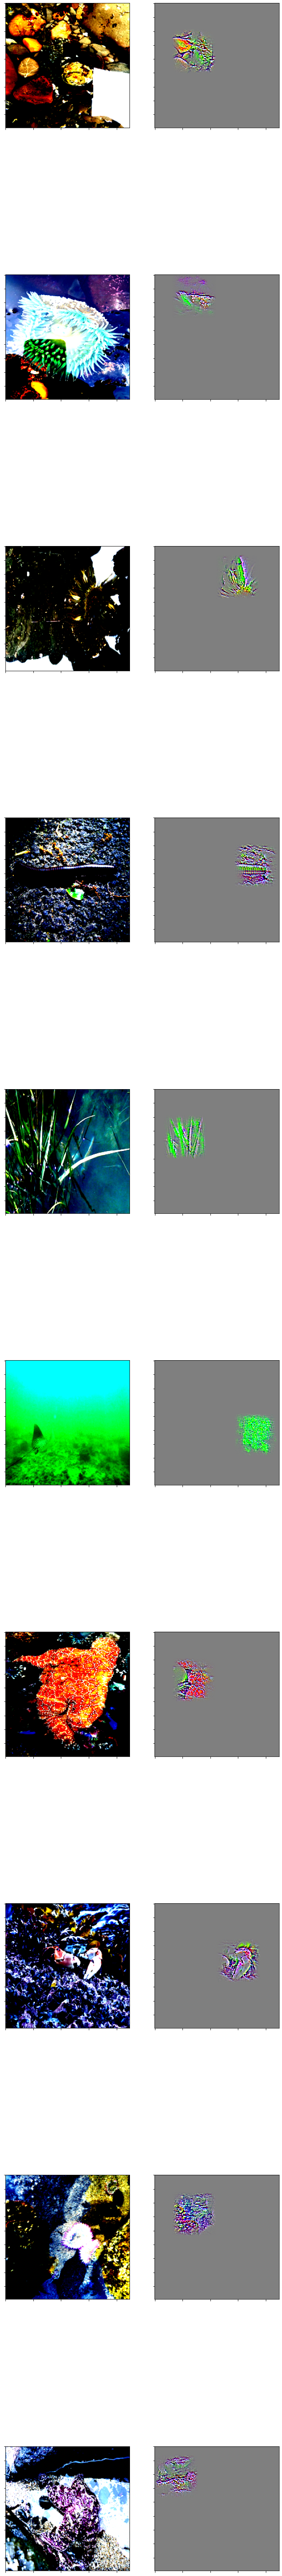

In [ ]:
data=[]

#generating 10 input and gradient lists
for i in range(10):
  d=random.randint(0,72)
  a,b=guidedprop(cnn1,x_test[d:d+1])
  data.append([a,b])
num=0

#plotting the images where each row will contain input and gradient image
fig, axs = plt.subplots(10, 2, figsize = (10, 100))
for count in range(10):
  axs[count,0].imshow(data[count][0])
  axs[count,0].set_yticklabels([])
  axs[count,0].set_xticklabels([])
  axs[count,1].imshow(data[count][1])
  axs[count,1].set_yticklabels([])
  axs[count,1].set_xticklabels([])
wandb.log({'Guided Back Propagation': [wandb.Image(fig)]})